This notebook looks at the network traffic during a typical CMSSW job, running over several input files served by xROOTD. This was run interactively on soolin.

Data was collected my monitoring the `cmsRun` process, using the following bash script, taken from: http://unix.stackexchange.com/a/6914

```shell
#!/bin/bash
#
# usage: bwmon PID

IN=0; OUT=0; TIME=0

get_traffic() {
    # use eth1 for soolin
    t=`awk '/eth1:/ { printf("%s,%d,%d\n",strftime("%s"),$2,$10); }' < /proc/$1/net/dev`
    IN=${t#*,}; IN=${IN%,*}
    OUT=${t##*,};
    TIME=${t%%,*};
}
echo "TIME,DTIME,IN,DIN,OUT,DOUT"
get_traffic $1
while true
do
    _IN=$IN; _OUT=$OUT; _TIME=$TIME
    get_traffic $1
    echo "$TIME,$(( $TIME - $_TIME )),$IN,$(( $IN - $_IN )),$OUT,$(( $OUT - $_OUT))"
    sleep 1
done
```

Note that the columns `DIN` and `DOUT` measure the difference in network traffic every second (in bits), so they are the RX/TX rates in bits/s

In [597]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib
import pandas as pd
from matplotlib import dates
import datetime

get_ipython().magic(u'pylab inline')
mpl.rcParams['figure.figsize'] = (14.0, 6.0)  # default size of plots
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.scatterpoints'] = 1

Populating the interactive namespace from numpy and matplotlib


In [598]:
# Read in our CSV log file and convert to a Dataframe
epoch_time_converter = lambda x : pd.to_datetime(x, unit='s') # converts from epoch time to normal time
df = pd.read_csv('cmsrun_bx.log', index_col=0, parse_dates=True, date_parser=epoch_time_converter)
df = df[df.DTIME==1]
# add column for in/out in MB/s, since DIN and DOUT are in Bit/s
convert_b_to_MB = np.vectorize(lambda x: float(x)/(8*1024*1024))
df['RX'] = df.DIN.apply(convert_b_to_MB)
df['TX'] = df.DOUT.apply(convert_b_to_MB)
df.head()

,DTIME,IN,DIN,OUT,DOUT,RX,TX
TIME,,,,,,,
2015-08-27 19:31:59,1,3297649294235,6022,1187876074849,77497,0.000718,0.009238
2015-08-27 19:32:00,1,3297649296695,2460,1187876085737,10888,0.000293,0.001298
2015-08-27 19:32:01,1,3297649298953,2258,1187876104078,18341,0.000269,0.002186
2015-08-27 19:32:02,1,3297649316751,17798,1187876139479,35401,0.002122,0.004220
2015-08-27 19:32:03,1,3297649337402,20651,1187876180238,40759,0.002462,0.004859


In [611]:
df.describe()

,DTIME,IN,DIN,OUT,DOUT,RX,TX
count,1312,1.312000e+03,1312.000000,1.312000e+03,1312.000000,1312.000000,1312.000000
mean,1,3.301448e+12,6008300.097561,1.187979e+12,162183.757622,0.716245,0.019334
std,0,2.336262e+09,10292131.963801,5.824875e+07,852656.685333,1.226918,0.101645
min,1,3.297649e+12,344.000000,1.187876e+12,507.000000,0.000041,0.000060
25%,1,3.299471e+12,2553.750000,1.187934e+12,4722.000000,0.000304,0.000563
50%,1,3.301253e+12,17300.000000,1.187973e+12,22398.000000,0.002062,0.002670
75%,1,3.303203e+12,12181905.750000,1.188027e+12,174455.250000,1.452196,0.020797
max,1,3.305799e+12,76584192.000000,1.188091e+12,18484415.000000,9.129547,2.203514


Note that all times are GMT, even though the log files are in BST.

We can also record the times of when files were opened/closed, and see if they correlate with any of the spikes:

In [599]:
df_events = pd.read_csv('cmsrun_files.log', index_col=0, parse_dates=True, dtype={'EVENT': str})
stripper = lambda x: x.strip()
df_events.EVENT = df_events.EVENT.apply(stripper)
df_events.head()

,EVENT
TIME,
2015-08-27 19:32:17,Initiating request to open file
2015-08-27 19:32:17,Fallback request to file
2015-08-27 19:32:20,Successfully opened file
2015-08-27 19:36:53,Closed file
2015-08-27 19:36:53,Initiating request to open file


In [600]:
s_init = df_events[df_events['EVENT'].str.contains("Initiating")].index
s_open = df_events[df_events['EVENT'].str.contains("opened")].index
s_closed = df_events[df_events['EVENT'].str.contains("Closed")].index
# s_init

Let's plot the RX/TX rates as a funciton of time, and histogram it to see the distribution of values.

In [618]:
def plot_lines(series, **kwargs):
    """Plot vertical lines using x values in arg series
    
    series must be of type pandas.tseries.index.DatetimeIndex
    """
    ax = plt.gca()
    fds = dates.date2num(series.to_pydatetime()) # converted
    return ax.vlines(fds, *ax.get_ylim(), **kwargs)


def format_date_axis():
    """Formats date axis (x) to some sinsible formatting"""
    plt.gca().xaxis.set_major_locator(dates.MinuteLocator())
    _ = plt.xticks(size=14, rotation=50)

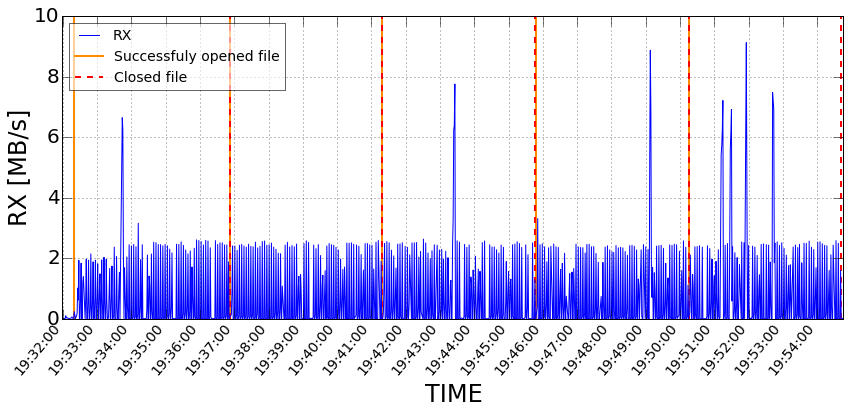

In [619]:
df.RX.plot()
# df.TX.plot(c='r', secondary_y=True)
plt.ylabel("RX [MB/s]")
plt.grid(b=True, which='both')
lw = 2
plot_lines(s_open, linestyles='-', label="Successfuly opened file", color='darkorange', lw=lw)
plot_lines(s_closed, linestyles='--', label="Closed file", color='red', lw=lw)
plt.legend(loc=0)
format_date_axis()

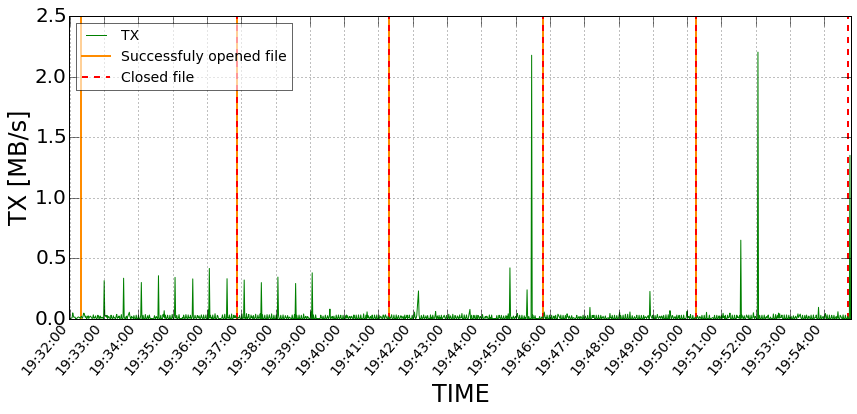

In [620]:
df.TX.plot(c='g')
plt.ylabel("TX [MB/s]")
plt.grid(b=True, which='both')
plot_lines(s_open, linestyles='-', label="Successfuly opened file", color='darkorange', lw=lw)
plot_lines(s_closed, linestyles='--', label="Closed file", color='red', lw=lw)
plt.legend(loc=0)
format_date_axis()

Interestingly, there seems to be an initial period of about 6 minutes where there is a roughly similar amount of data transmitted every 30s.

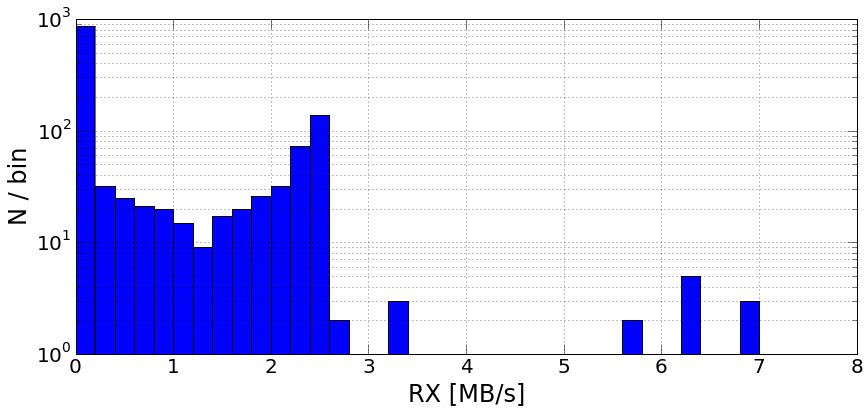

In [604]:
df.RX.plot(kind='hist', bins=40, logy=True, range=[0,8])
plt.grid(b=True, which='both')
plt.xlabel('RX [MB/s]')
plt.ylabel('N / bin')

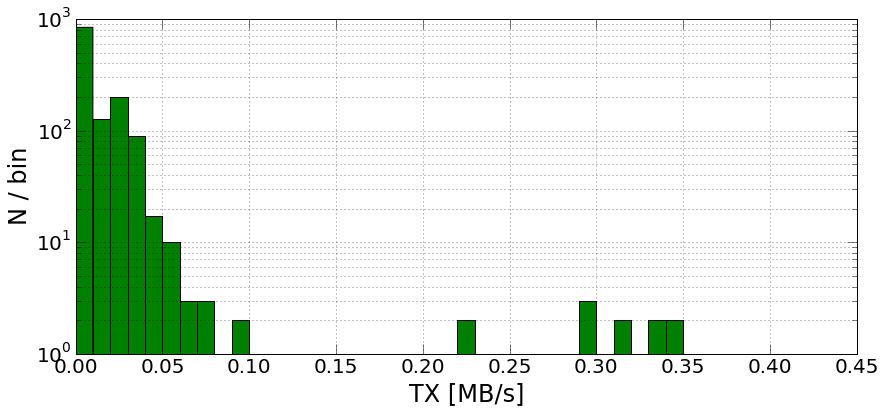

In [605]:
df.TX.plot(kind='hist', bins=40, logy=True, range=[0,0.4], color='g')
plt.grid(b=True, which='both')
plt.xlabel('TX [MB/s]')
plt.ylabel('N / bin')

Let's look at the total data transmitted in/out as function of time.

In [606]:
# Make a mini Dataframe with just IN & OUT columns
df_inout = df.ix[:,['IN', 'OUT']]
# convert to MB instead of bits
df_inout['IN'] = df_inout.IN.apply(convert_b_to_MB)
df_inout['OUT'] = df_inout.OUT.apply(convert_b_to_MB)
# subtract off a constant - dunno what that is? some intial large file transfer?
df_inout['IN'] = df_inout.IN.apply(lambda x: x-df_inout.IN[0])
df_inout['OUT'] = df_inout.OUT.apply(lambda x: x-df_inout.OUT[0])

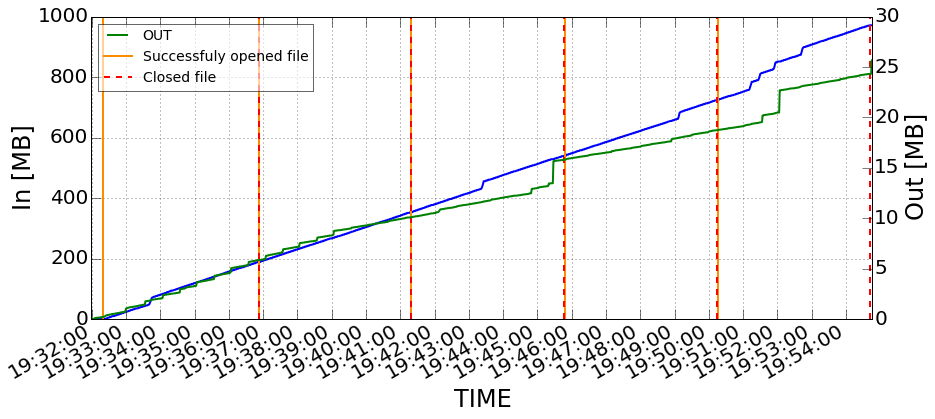

In [621]:
ax = df_inout.plot(secondary_y=['OUT'], legend=None, lw=lw)
ax.set_ylabel('In [MB]')
ax.right_ax.set_ylabel('Out [MB]')
ax.grid(b=True, which='both')
plot_lines(s_open, linestyles='-', label="Successfuly opened file", color='darkorange', lw=lw)
plot_lines(s_closed, linestyles='--', label="Closed file", color='red', lw=lw)
plt.legend(loc=0)
format_date_axis()

Conclusions so far:

1) The average incoming rate is ~ 2.5MB/s, whilst the average outgoing rate is ~ 0.025MB/s

2) There are occasional 'spikes' in the RX/TX rate, which are not correlated with the opening/closing of files

Let's look at the RX/TX graphs a bit more closely:

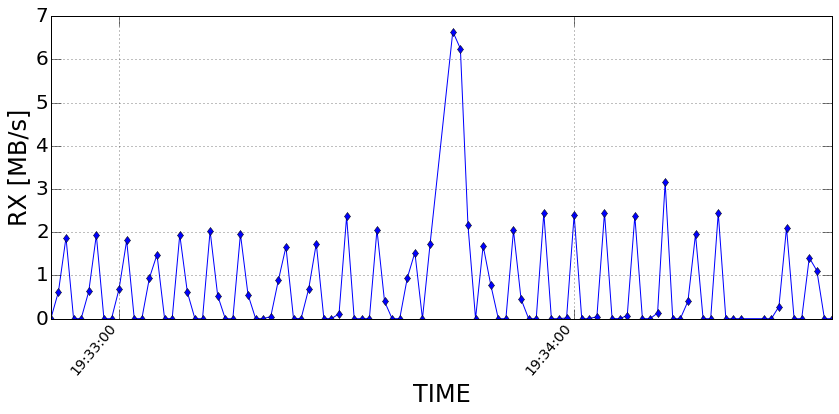

In [622]:
df[50:150].RX.plot(marker='d')
plt.ylabel('RX [MB/s]')
locator = dates.AutoDateLocator()
format_date_axis()

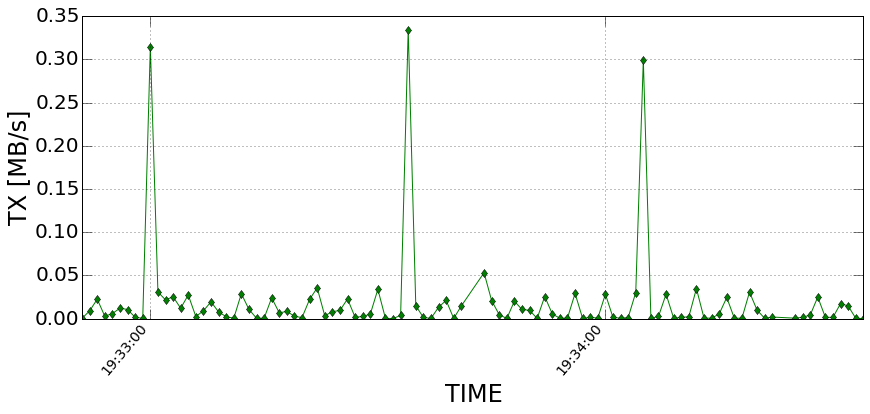

In [623]:
df[50:150].TX.plot(marker='d', c='g')
plt.ylabel('TX [MB/s]')
format_date_axis()